# Setting up Paths

In [8]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
#path to compasrepo which contains ther popsynth folder
pathPostProcessing = '/Users/floorbroekgaarden/Projects/BHNS_project/Scripts'




# Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import os
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')

# Custom Imports from COMPASrepo

In [10]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
import coencodeVarious        as CV



# General Idea

In this notebook we calculate the 2D arrays that contains the probability of observing each system in each redshift shell. We will save these values to h5 file so we only have to do it once


In [19]:
fname = 'VariationIntegration.h5'
if os.path.isfile(fname):
    test = False
    print "File exists wont do next sells else I overwrite results"
else:
    test = True
    hf = h5.File(fname, 'w')

### MSSFR variations

In [20]:
SFRs    = ['Madau et al. (2014)', 'Strolger et al. (2004)']
MZs     = ['Ma et al. (2015)', 'Langer et al. (2006)', 'Langer et al. +offset (2006)']
GSMFs   = ['Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Furlong et al. (2015) Double']


#In princple the whole routine is a series of nested loops, to make the code readable 
#I precombine here and afterwards I do not need to do for SFR in /for MZ in /for GSMF in
#but instead for variation in Variations

#each sublist is ordered SFR, MZ, GSMF
counter    = 0
Variations = []
if test is True:
    for SFR in SFRs:
        for MZ in MZs:
            for GSMF in GSMFs:
                counter += 1
                hf.create_group(str(counter)+'/BBH')
                hf.create_group(str(counter)+'/BNS')
                hf.create_group(str(counter)+'/BHNS')
                Variation = [SFR, MZ, GSMF]
                newGroup = hf[str(counter)]
                newGroup.create_dataset('SFR_MZ_GSMF', data=Variation)

    print hf.keys()
    print hf['1']['SFR_MZ_GSMF'][...][0]
    #print Variations

[u'1', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']
Madau et al. (2014)


In [26]:
print hf['1']['SFR_MZ_GSMF'][...][0]

ValueError: Not a location (invalid object ID)

### DCO types and redshift integral shells

 The maximum redshift at which we can observe a BBH merger differs from BNS.
To not waste calculating empty shells (since we only care about obsevable mergers) and keep a high enough resolution
we take different intervals for the cosmic integration for each DCO type. If the outmost shell still contains an observable merger the cosmicIntegation class will raise a warning.

In [14]:
Types = ['BBH', 'BNS', 'BHNS']
minz  = [  0,     0,     0   ]
maxz  = [  2.,    0.3,   0.5 ]
nrz   = 100
    

# The Cosmic Integration

In [21]:

#It takes the longest to create instance of CosmicIntegrator given the Type
#Hence this is the outermost loop
if test is True:
    for nrT, Type in enumerate(Types):
        print Type
        #This creates a 2D array of merger rates per redshift per systems
        #Prepares all the delay time conversions and redshifts. Takes some time
        Data      = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes=Type,\
                    minRedshift=minz[nrT],   maxRedshift=maxz[nrT], nrRedshiftBins=nrz, optimistic=True)
        counter = 0
        for Variation in hf.keys():
            counter+=1
            print counter
            Data.MSSFR.Zprescription         = 'MZ_GSMF'
            Data.MSSFR.SFRprescription       = hf[Variation]['SFR_MZ_GSMF'][...][0]
            Data.MSSFR.ZMprescription        = hf[Variation]['SFR_MZ_GSMF'][...][1]
            Data.MSSFR.GSMFprescription      = hf[Variation]['SFR_MZ_GSMF'][...][2]
            Data.cosmologicalIntegration()
            weightSTROOPWAFEL = Data.COMPAS.weight
            RatePerSystemObserved = np.sum(Data.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0)

            group = hf[Variation][Type]

            group.create_dataset('ObservedRate', data=RatePerSystemObserved)
            group.create_dataset('randomSeed',   data=Data.COMPAS.seeds)
            group.create_dataset('chirpMass',    data=Data.COMPAS.mChirp)
            #I specificilly did optimistic here so I can flag pessimistic in postProcessing
            group.create_dataset('Pessimistic',  data=Data.COMPAS.pessimictic_subSet)
            RatePerSystemRedshift0        = Data.PerSystemPerRedshift_ratesIntrinsic*weightSTROOPWAFEL[0]
            group.create_dataset('IntrinsicRedshift0', data=RatePerSystemRedshift0)
    hf.close()

BBH
weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
1
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
2
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
3
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
4
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
5
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
6
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
7
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
8
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
9
The detected rate of the outermost redshift shell is nonzero, did we integrate far enough?
10
The detected rate of the outermost redshift shell is nonzero, did we

In [22]:
print()
print('----- BH - BH -----')

h5file           = h5.File('VariationIntegration.h5')
print h5file['1']['BBH'].keys()
print h5file['1']['BBH']['ObservedRate'][...]
print h5file['1']['BBH']['randomSeed'][...]
print h5file['1']['BBH']['IntrinsicRedshift0'][...]

print()
print('----- BH - NS -----')

print h5file['1']['BHNS'].keys()
print h5file['1']['BHNS']['ObservedRate'][...]
print h5file['1']['BHNS']['randomSeed'][...]
print h5file['1']['BHNS']['IntrinsicRedshift0'][...]


print()
print('----- NS - NS -----')

print h5file['1']['BNS'].keys()
print h5file['1']['BNS']['ObservedRate'][...]
print h5file['1']['BNS']['randomSeed'][...]
print h5file['1']['BNS']['IntrinsicRedshift0'][...]

()
----- BH - BH -----
[u'IntrinsicRedshift0', u'ObservedRate', u'Pessimistic', u'chirpMass', u'randomSeed']
[4.68668331e-05 2.31059411e-05 1.96262781e-06 ... 2.80381358e-02
 5.55327279e-02 1.24694821e-01]
[4730000024 4730000087 4730000137 ... 7635086628 7635090801 7635097571]
[[4.62594293e-07 2.64547640e-07 3.93355690e-06 ... 1.65375718e-01
  2.48204130e-01 2.07888191e-01]
 [4.89441186e-07 2.78556449e-07 4.26316379e-06 ... 1.69150194e-01
  2.53472138e-01 2.12507642e-01]
 [5.17370241e-07 2.93053777e-07 4.61770087e-06 ... 1.72949588e-01
  2.58748646e-01 2.17173916e-01]
 ...
 [2.76566947e-05 1.13884849e-05 0.00000000e+00 ... 3.42933615e-01
  2.32976130e-02 1.68761051e-01]
 [2.82703020e-05 1.16955099e-05 0.00000000e+00 ... 3.40023369e-01
  2.06155339e-02 1.62127434e-01]
 [2.88778100e-05 1.20089066e-05 0.00000000e+00 ... 3.36983736e-01
  1.81615551e-02 1.55554841e-01]]
()
----- BH - NS -----
[u'IntrinsicRedshift0', u'ObservedRate', u'Pessimistic', u'chirpMass', u'randomSeed']
[8.02191151e-

In [29]:
print np.sum((h5file['1']['BBH']['ObservedRate'][...]))

591.7305891217312


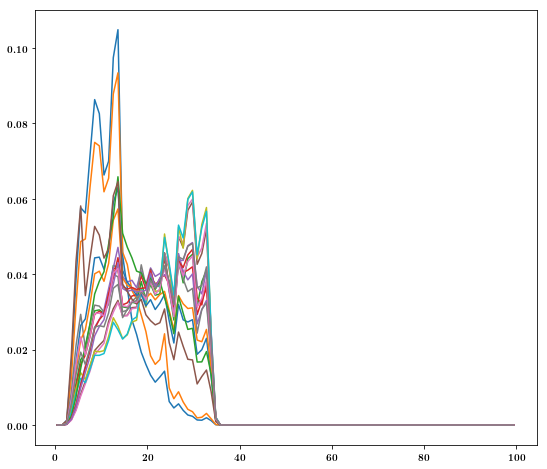

In [23]:
fig, axes = plt.subplots(1,1, figsize=(9,8))

MchirpBins = np.linspace(0,100,100)
center     = (MchirpBins[1:]+MchirpBins[:-1])/2.
dMchirp    = np.diff(MchirpBins)

for variation in h5file.keys():
    Mchirp     = h5file[variation]['BBH']['chirpMass'][...].squeeze()
    Rate       = h5file[variation]['BBH']['ObservedRate'][...].squeeze()
    hist, bins = np.histogram(Mchirp, bins=MchirpBins, weights=Rate)
    y          = np.divide(hist, dMchirp)
    y          = y / float(np.sum(y))
    axes.plot(center, y)
plt.show()

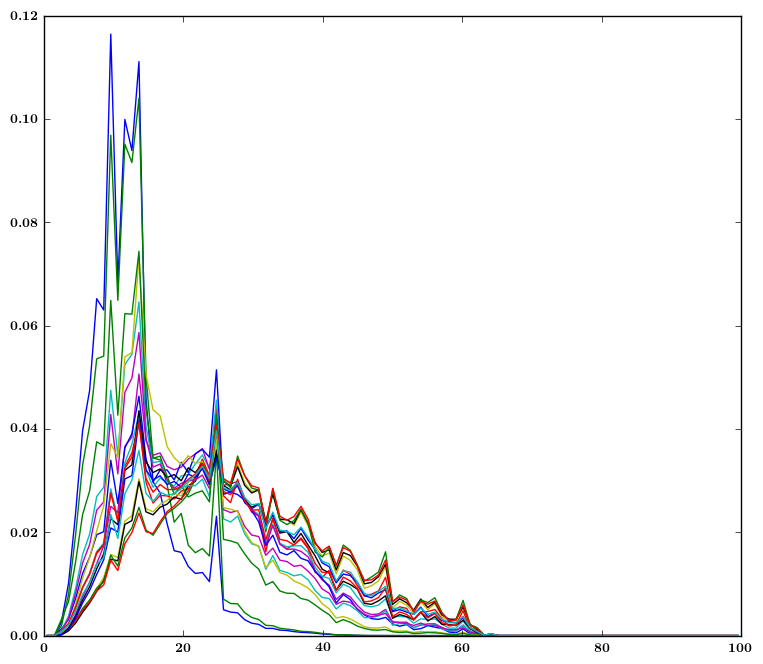

In [9]:
fig, axes = plt.subplots(1,1, figsize=(9,8))

MchirpBins = np.linspace(0,100,100)
center     = (MchirpBins[1:]+MchirpBins[:-1])/2.
dMchirp    = np.diff(MchirpBins)

for variation in h5file.keys():
    Mchirp     = h5file[variation]['BBH']['chirpMass'][...].squeeze()
    Rate       = h5file[variation]['BBH']['ObservedRate'][...].squeeze()
    hist, bins = np.histogram(Mchirp, bins=MchirpBins, weights=Rate)
    y          = np.divide(hist, dMchirp)
    y          = y / float(np.sum(y))
    axes.plot(center, y)
plt.show()